# **LDA Topic modeling using both published and public resources dataset for training and testing**

In [1]:
import csv
import re
import pandas as pd
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from collections import defaultdict

# We need this dataset in order to use the tokenizer
#nltk.download('punkt')
#import nltk
#nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk import flatten
# Also download the list of stopwords to filter out
#nltk.download('stopwords')
from nltk.corpus import stopwords, wordnet as wn
#nltk.download('wordnet')def get_wordnet_pos(treebank_tag):

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

from nltk import pos_tag

import numpy
numpy.random.seed(1) # setting random seed to get the same training model results each time.

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

# these resources are all test resources,which may need to be filtered out from input data
bad_data_id = {
    "c40d9567678740dab868f35440a69b30",
    "c28359056de64680bbdfc64514e1f599",
    "9d5ac26acb8c404fb9ab6e3573ec2c49",
    "316018ccfbdf47928687f81e1b0deb68",
    "fa27117fdf8a462ca320e618dea9a576",
    "9981d0052ae44546912be39ac786a0f9"
}

import pyLDAvis

stop_words = stopwords.words('english')
custom_stop_words = ['include', 'included', 'includes', 'including', 'contain', 'contains', 'containing', 'file', 'et', 'al', 'different', 
                    'dat', 'edu', 'not', 'would', 'say', 'could', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 
                     'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'from', 'published', 
                     'christina', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come', 'used', 'using', 'use', 'public', 
                     'private', 'new', 'west', 'east', 'south', 'north', 'approximately', 'four', 'low', 'high', 'available', 'mile', 'daily', 
                     'year', 'month', 'variable', 'square', 'city', 'foot', 'area', 'within', 'provide', 'firm', 'file', 'state', 'information', 
                     'well', 'university']
stop_words.extend(custom_stop_words)



def process_text(text):
    # Make all the strings lowercase
    text = text.lower()
    # remove urls
    text = re.sub('http[s]?://\S+', '', text)
    # remove non alphabetic characters except dash symbol which is converted to underbar that indicates phrases
    text = re.sub('[-]', '_', text)
    text = re.sub('[^A-Za-z_]', ' ', text.lower())

    # Tokenize the text; this is, separate every sentence into a list of words
    # Since the text is already split into sentences you don't have to call sent_tokenize
    tokenized_text = word_tokenize(text)
    
    tag_map = defaultdict(lambda : wn.NOUN)    
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV    
    
    # Remove the stopwords and lemmatize each word
    clean_text = [
        lemmatizer.lemmatize(word[1:] if word.startswith('_') else word, tag_map[tag[0]]) for word, tag in pos_tag(tokenized_text)
        if word not in stop_words and len(word)>2
    ]
    # this final output is a list of words - remove stop words from lemmatized text to completely remove stop words
    return [word for word in clean_text if word not in stop_words] 

def process_keyword(keyword):
    # remove paratheses
    text = re.sub('\([^()]*\)', '', keyword)
    text = text.strip()    
    # convert dash and space symbols to underbar that indicates phrases
    text = re.sub('[- ]', '_', text)
    return text


In [2]:
# read all published and public hydroshare data
file_name = '/projects/hackathon/ML-Training/hs-ml/data/hs_data.csv'
all_data = [row for row in csv.reader(open(file_name))]
# Remove the first row, since it only has the labels
all_data = all_data[1:]
print('total number of data instances:', len(all_data))

# process keywords
keywords = [row[3].lower().strip().strip(';').split(';') for row in all_data]
for i, kw_list in enumerate(keywords):
    for j, kw in enumerate(kw_list):
        kw_list[j] = process_keyword(kw)
print("total number of keywords: ", len(keywords))


total number of data instances: 4228
total number of keywords:  4228


In [3]:
# concatenate title and abstract to prepare for training texts
all_texts = ['{} {}'.format(row[2], row[4]) for row in all_data]
for i, text in enumerate(all_texts):
    kw_text = ' '.join(keywords[i])
    all_texts[i] = '{} {}'.format(text, kw_text) 

print("Number of full text rows:", len(all_texts))
keywords_set = set(flatten(keywords))
print("number of keywords in keywords_set", len(keywords_set))
#print(keywords_set)


Number of full text rows: 4228
number of keywords in keywords_set 4723


In [4]:
# split total_data into train and test data
from sklearn.model_selection import train_test_split

input_data, test_data, input_keywords, test_keywords = train_test_split(all_texts, keywords, test_size=0.2, train_size=0.8)
print("length of training data: ", len(input_data), ", length of test data: ", len(test_data))

length of training data:  3382 , length of test data:  846


In [5]:
%time docs = [process_text(text) for text in input_data]
#Create Biagram & Trigram Models 
from gensim.models import Phrases
# Add bigrams and trigrams to texts
# higher threshold means few phrases, heavily depends on scoring function, which can be set as 'default' or 'npmi'
bigram = Phrases(docs, min_count=5, threshold=10, scoring='default') 
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token and token not in docs[idx]:
            # Token is a bigram, add to document.
            docs[idx].append(token)
            #print("in bigram processing: ", token)
    for token in trigram[docs[idx]]:
        if '_' in token and token not in docs[idx]:
            # Token is a bigram, add to document.
            docs[idx].append(token)
            #print("in trigram processing: ", token)


CPU times: user 25.9 s, sys: 385 ms, total: 26.3 s
Wall time: 26.3 s


In [6]:
docs_dictionary = Dictionary(docs)
#docs_dictionary.filter_extremes(no_below=10, no_above=0.2)
corpus = [docs_dictionary.doc2bow(text) for text in docs]
print('number of documents in corpus', len(corpus))
print(docs_dictionary)
#print(docs_dictionary.token2id)

number of documents in corpus 3382
Dictionary(19086 unique tokens: ['across', 'along', 'analysis', 'analysis_system', 'analysis_system_fia_flood']...)


## **Find a good value for the number of topics by comparing coherence score of different models**

In [7]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3, coherence='c_v'):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
    start : the start number of topics
    step : the step size for the number of topics iteration
    coherence: either 'c_v' or 'u_mass' coherence measure
    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # symmetric alpha is default, can also set it to "auto" and 'asymmetric'
        model=LdaModel(corpus=corpus, id2word=dictionary, alpha='auto', num_topics=num_topics, passes=15)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence=coherence)
        coherence_values.append(coherencemodel.get_coherence())
        print(num_topics, coherence)
    
    return model_list, coherence_values

limit=40; start=2; step=2;
%time model_list, coherence_values = compute_coherence_values(dictionary=docs_dictionary, corpus=corpus, texts=docs, start=start, limit=limit, step=step)

%time umass_model_list, umass_coherence_values = compute_coherence_values(dictionary=docs_dictionary, corpus=corpus, texts=docs, start=start, limit=limit, step=step, coherence='u_mass')


2 c_v
4 c_v
6 c_v
8 c_v
10 c_v
12 c_v
14 c_v
16 c_v
18 c_v
20 c_v
22 c_v
24 c_v
26 c_v
28 c_v
30 c_v
32 c_v
34 c_v
36 c_v
38 c_v
CPU times: user 20min 17s, sys: 19.8 s, total: 20min 36s
Wall time: 26min 13s
2 u_mass
4 u_mass
6 u_mass
8 u_mass
10 u_mass
12 u_mass
14 u_mass
16 u_mass
18 u_mass
20 u_mass
22 u_mass
24 u_mass
26 u_mass
28 u_mass
30 u_mass
32 u_mass
34 u_mass
36 u_mass
38 u_mass
CPU times: user 18min 44s, sys: 16.6 s, total: 19min 1s
Wall time: 24min 20s


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


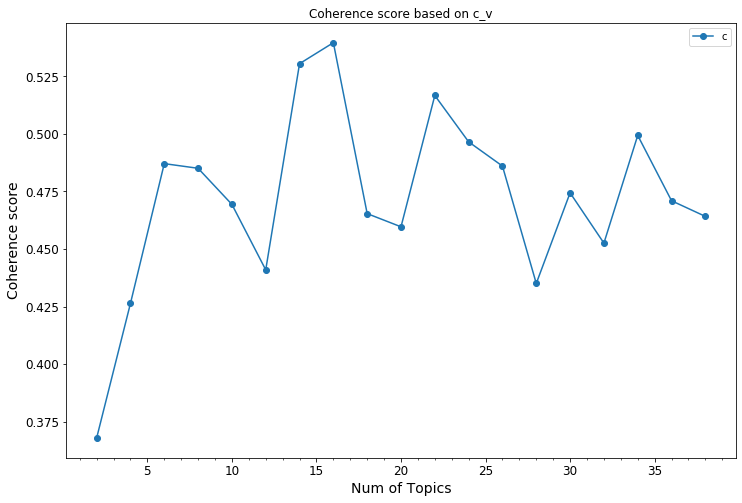

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


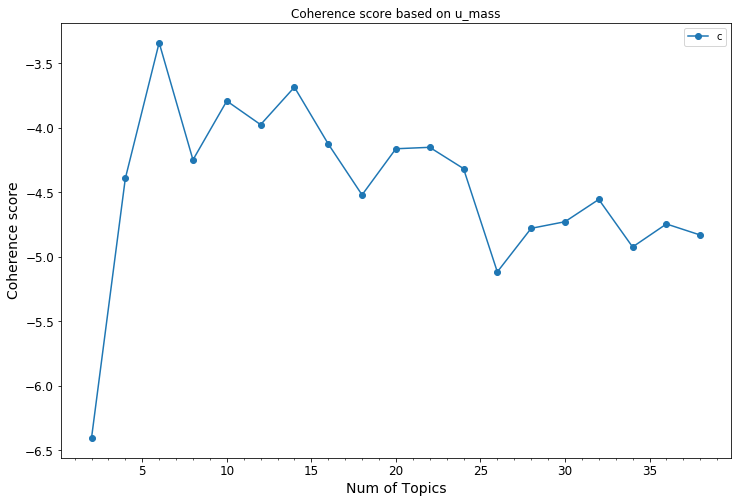

In [8]:
# Show graph
x = range(start, limit, step)
plt.figure(figsize=(12, 8))
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.plot(x, coherence_values, marker='o')
plt.xlabel("Num of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.title('Coherence score based on c_v')
plt.axes().xaxis.set_minor_locator(AutoMinorLocator())
plt.show()

plt.figure(figsize=(12, 8))
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.plot(x, umass_coherence_values, marker='o')
plt.xlabel("Num of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.title('Coherence score based on u_mass')
plt.axes().xaxis.set_minor_locator(AutoMinorLocator())
plt.show()

In [7]:

# train an LDA model to instruct Gensim to find specified number of topics
# symmetric alpha is default, can also set it to "auto" and 'asymmetric'
# per_word_topics, if set to true, the model also computes a list of topics, sorted in descending order of most likely topics for each word 
# along with their phi values multiplied by the feature length (i.e., word count)
num_of_topics = 6
%time model = LdaModel(corpus, num_topics=num_of_topics, alpha='auto', id2word=docs_dictionary, passes=15, per_word_topics=True)


#topics = model.show_topics(num_words=10, formatted=False)
#print("topics shape: ", model.get_topics().shape)
#for topic in topics:
#    print(topic)
#top_topics = model.top_topics(corpus=corpus, texts=docs, dictionary=docs_dictionary, topn=10, coherence='c_v')
#print("top topics using c_v coherence measure: ")
#for topic in top_topics:
#    print(topic, '\n')


CPU times: user 55.8 s, sys: 1.58 s, total: 57.3 s
Wall time: 31.9 s


In [8]:
from pprint import pprint
pprint(model.print_topics())

[(0,
  '0.041*"river" + 0.028*"watershed" + 0.024*"usace" + 0.021*"cwm" + '
  '0.014*"basin" + 0.012*"usace_cwm" + 0.011*"resource" + 0.011*"collection" + '
  '0.010*"water" + 0.008*"model"'),
 (1,
  '0.027*"precipitation" + 0.026*"historic" + 0.018*"data" + 0.017*"republic" '
  '+ 0.016*"dominican" + 0.014*"discharge" + 0.011*"model" + '
  '0.010*"temperature" + 0.008*"indrhi" + 0.008*"dominican_republic"'),
 (2,
  '0.017*"water" + 0.016*"soil" + 0.010*"temperature" + 0.008*"data" + '
  '0.006*"change" + 0.005*"model" + 0.004*"study" + 0.004*"sensor" + '
  '0.004*"depth" + 0.004*"climate"'),
 (3,
  '0.030*"data" + 0.019*"model" + 0.011*"flow" + 0.011*"water" + 0.010*"river" '
  '+ 0.009*"groundwater" + 0.007*"discharge" + 0.006*"stream" + '
  '0.005*"temperature" + 0.005*"time"'),
 (4,
  '0.024*"data" + 0.019*"model" + 0.011*"water" + 0.011*"resource" + '
  '0.009*"hydroshare" + 0.006*"hydrologic" + 0.006*"research" + '
  '0.006*"support" + 0.006*"project" + 0.005*"map"'),
 (5,
  '0.0

In [9]:
pprint(model.top_topics(texts=docs, coherence='c_v', topn=10))

[([(0.02430494, 'data'),
   (0.018599713, 'model'),
   (0.010928231, 'water'),
   (0.010851577, 'resource'),
   (0.00929926, 'hydroshare'),
   (0.006471285, 'hydrologic'),
   (0.0059764576, 'research'),
   (0.005752156, 'support'),
   (0.0056883395, 'project'),
   (0.0048096688, 'map')],
  0.5948841629818096),
 ([(0.04113306, 'river'),
   (0.02827205, 'watershed'),
   (0.024401154, 'usace'),
   (0.021166084, 'cwm'),
   (0.014236276, 'basin'),
   (0.0115012275, 'usace_cwm'),
   (0.011092337, 'resource'),
   (0.010752686, 'collection'),
   (0.01043818, 'water'),
   (0.008241375, 'model')],
  0.5358840282525519),
 ([(0.030109692, 'data'),
   (0.018660389, 'model'),
   (0.011465083, 'flow'),
   (0.010651733, 'water'),
   (0.009536294, 'river'),
   (0.008699693, 'groundwater'),
   (0.0073143924, 'discharge'),
   (0.005989062, 'stream'),
   (0.004936503, 'temperature'),
   (0.004870129, 'time')],
  0.4975395613152167),
 ([(0.016845126, 'water'),
   (0.015790077, 'soil'),
   (0.009551679, 'te

## **Find dominant topic, its percentage contribution, and cosine similarity between topic keywords and curated keywords in each document instance**

In [11]:
pd.options.display.max_colwidth = 100

sent_topics_df = pd.DataFrame()

for i, row_list in enumerate(model[corpus]):
    row = row_list[0] if model.per_word_topics else row_list
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    for j, (topic_num, prop_topic) in enumerate(row):
        if j == 0:
            wp = model.show_topic(topic_num)
            topic_keywords_list = [word for word, prop in wp]
            topic_keywords = "; ".join(topic_keywords_list)
            # compute cosine similarity between topic keywords and input keywords
            topic_keywords_set = {w for w in topic_keywords_list}
            input_keywords_set = {w for w in input_keywords[i]}
            #rvector = topic_keywords_set.union(input_keywords_set)
            rvector = input_keywords_set
            l1 = []; l2 = []
            for w in rvector:
                if w in topic_keywords_set:
                    l1.append(1)
                else:
                    l1.append(0)
                if w in input_keywords_set:
                    l2.append(1)
                else:
                    l2.append(0)
            dot_product = sum(n1*n2 for n1, n2 in zip(l1, l2))
            mag1 = sum(l1)**0.5
            mag2 = sum(l2)**0.5
            if mag1 == 0 or mag2 == 0:
                cos_sim = 0
            else:    
                cos_sim = dot_product/(mag1*mag2)
            sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords, input_keywords[i], cos_sim]), ignore_index=True)
        else:
            break
            
contents = pd.Series(docs)
sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
sent_topics_df.reset_index()
sent_topics_df.columns = ['Dominant_Topic', 'Percent_Contribution', 'Topic_Keywords', 'Curated', 'Similarity', 'Text']
sent_topics_df


,Dominant_Topic,Percent_Contribution,Topic_Keywords,Curated,Similarity,Text
0,0.0,0.9986,river; watershed; usace; cwm; basin; usace_cwm; resource; collection; water; model,"[ressim, geohms, usace, iwrss, usace_corps_water_management_system, fia, ras, kansas_river_water...",0.353553,"[usace, cwm, kansas, river, watershed, corp, water, management, system, cwms, interrelated, mode..."
1,0.0,0.9501,river; watershed; usace; cwm; basin; usace_cwm; resource; collection; water; model,[watershed],1.000000,"[watershed, test, watershed, test, watershed]"
2,1.0,0.9583,precipitation; historic; data; republic; dominican; discharge; model; temperature; indrhi; domin...,[dem],0.000000,"[logan, dem, test, hydrods, service, dem]"
3,0.0,0.9876,river; watershed; usace; cwm; basin; usace_cwm; resource; collection; water; model,[corps_water_management_system],0.000000,"[usace, cwm, cape, fear, watershed, centerline, usace, cwm, cape, fear, watershed, collection, r..."
4,1.0,0.9972,precipitation; historic; data; republic; dominican; discharge; model; temperature; indrhi; domin...,"[temperature, fire, rain, humidity, weather, solar_radiation, soil_moisture, empire_fire, precip...",0.426401,"[illilouette, creek, basin, weather, station, data, part, project, study, effect, wildfire, illi..."
...,...,...,...,...,...,...
3377,2.0,0.9057,water; soil; temperature; data; change; model; study; sensor; depth; climate,"[germination, wetlands, plant_restoration, regeneration_traits]",0.000000,"[improve, native, specie, recruitment, seed_based, wetland, restoration, one, great, threat, gre..."
3378,3.0,0.9807,data; model; flow; water; river; groundwater; discharge; stream; temperature; time,"[demo, jupyterhub]",0.000000,"[hello, jupyterhub, demo, hydroshare, python, notebook, server, demo, jupyterhub, jupyterhub_dem..."
3379,2.0,0.5539,water; soil; temperature; data; change; model; study; sensor; depth; climate,"[vic, landslide, hydrology, north_cascades, national_park, landlab]",0.000000,"[regional, landslide, hazard, landlab, noca, observatory, noca, landslide, observatory, host, dr..."
3380,2.0,0.6274,water; soil; temperature; data; change; model; study; sensor; depth; climate,"[reduction_potential, bigelow_site, catalina_jemez, soil_redox_potential]",0.000000,"[cjczo, soil, redox, potential, bigelow, site, reduction, redox, potential, measure, continuousl..."


In [12]:
sent_topics_df.to_csv('training_topic_info_data_frame_accurate.csv')

In [18]:
import numpy as np
sim_series = sent_topics_df['Similarity']
zero_cnt = sim_series.astype(bool).sum()
print("mean of similarity measures: ", sim_series.mean())
print("number of zeros:", zero_cnt, "number of non-zeros:", sim_series.count()-zero_cnt)
print("mean of non-zero similarity measures: ", sim_series.replace(0, np.NaN).mean())

mean of similarity measures:  0.1928829760165733
number of zeros: 970 number of non-zeros: 2412
mean of non-zero similarity measures:  0.6725053864825267


## **Find the most representative text for each topic in training data**

In [19]:
sent_topics_sorted_df = pd.DataFrame()
sent_topics_grp_df = sent_topics_df.groupby('Dominant_Topic')
for i, grp in sent_topics_grp_df:
    sent_topics_sorted_df = pd.concat([sent_topics_sorted_df, grp.sort_values(['Percent_Contribution'], ascending=False).head(1)], axis=0)

print("Mean of dominant_topic_percent_contribution: ", sent_topics_sorted_df[['Percent_Contribution']].mean(axis=0))

# Reset Index    
sent_topics_sorted_df.reset_index(drop=True, inplace=True)
sent_topics_sorted_df


Mean of dominant_topic_percent_contribution:  Percent_Contribution    0.999217
dtype: float64


,Dominant_Topic,Percent_Contribution,Topic_Keywords,Curated,Similarity,Text
0,0.0,0.9994,river; watershed; usace; cwm; basin; usace_cwm; resource; collection; water; model,"[ressim, geohms, usace, lehigh__watershed, schuykill_watershed, usace_corps_water_management_sys...",0.316228,"[usace, cwm, delaware, river, watershed, corp, water, management, system, cwms, interrelated, mo..."
1,1.0,0.9989,precipitation; historic; data; republic; dominican; discharge; model; temperature; indrhi; domin...,"[temperature, wind_direction, snow_depth, other_instrumented_sites, meteorology, wind_gust_speed...",0.353553,"[ssczo, meteorology, meet, station, krew, bull, creek, lower, click, parent, folder, access, dat..."
2,2.0,0.9990,water; soil; temperature; data; change; model; study; sensor; depth; climate,"[saprolite, soil_formation, regolith, critcal_zone, chemical_weathering]",0.000000,"[lczo_, geology, regolith, survey, lithological, influence, contemporary, long_term, regolith, w..."
3,3.0,0.9993,data; model; flow; water; river; groundwater; discharge; stream; temperature; time,"[surface_groundwater, bertrand_creek, nooksack, modflow, wria1, topnet_wm]",0.000000,"[numerical, model, development, coupled, surface_groundwater, interaction, nooksack, basin, surf..."
4,4.0,0.9994,data; model; water; resource; hydroshare; hydrologic; research; support; project; map,"[fair, maria2017, hurricane, drinking_water, cyberinfrastructure, hydroshare]",0.408248,"[building, research, software, infrastructure, prevent, disaster, like, hurricane, maria, nsf, r..."
5,5.0,0.9993,data; pequea; dissolve; creek; site; mmw; watershed; model_my_watershed; mmw_model_my_watershed;...,"[neodymium,_dissolved, bromide,_dissolved, nitrogen,_dissolved_nitrite, fluorescence_index, thul...",0.000000,"[cjczo, soil, water, chemistry, santa, catalina, mountain, soil, solution, sample, scm, field, s..."


## **Word Clouds of Top 10 Keywords in Each Topic**

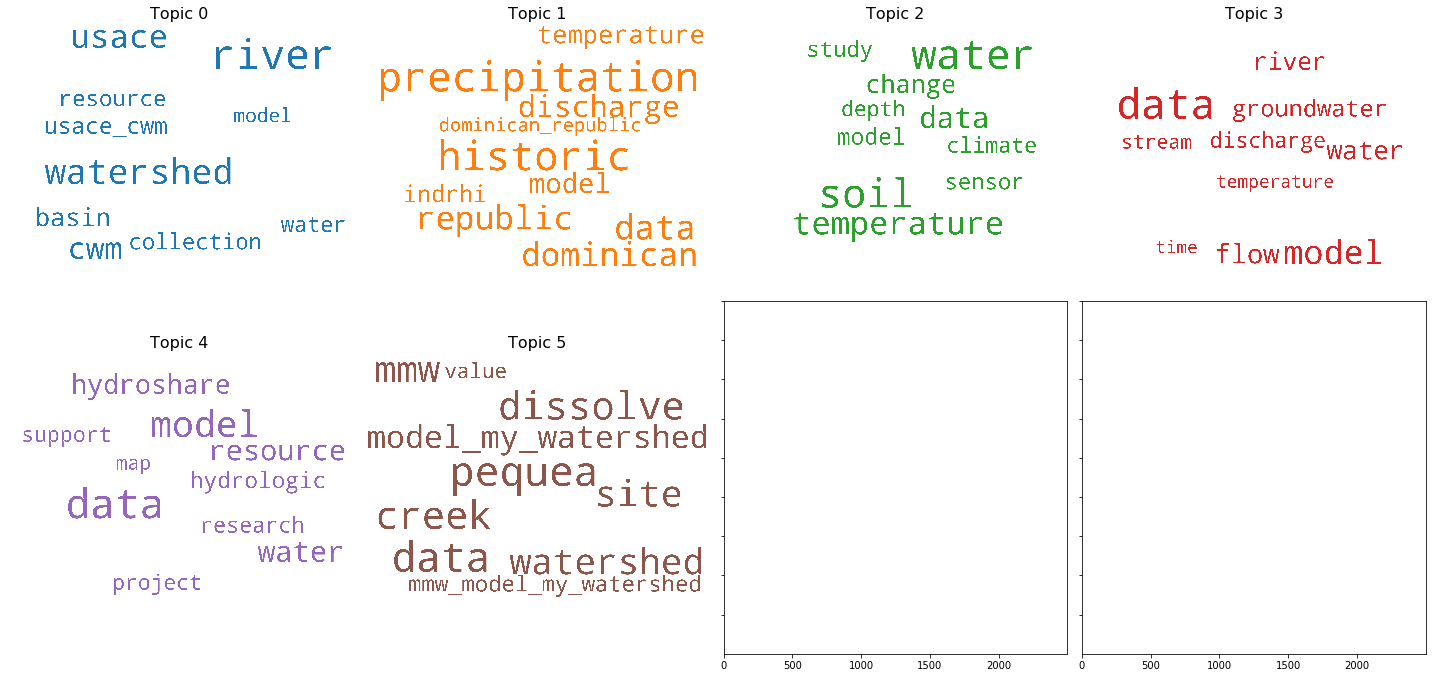

In [20]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors


def topics_per_document(model, corpus, start=0, end=-1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, word_topics, word_phi_values = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)


cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
topics = model.show_topics(num_topics=num_of_topics, formatted=False)

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i-len(cols)] if i >= len(cols) else cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(2, 4, figsize=(20,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    if i >= len(topics):
        break
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
dominant_topics, topic_percentages = topics_per_document(model=model, corpus=corpus)  

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## **Word Counts of Top Topic Keywords**

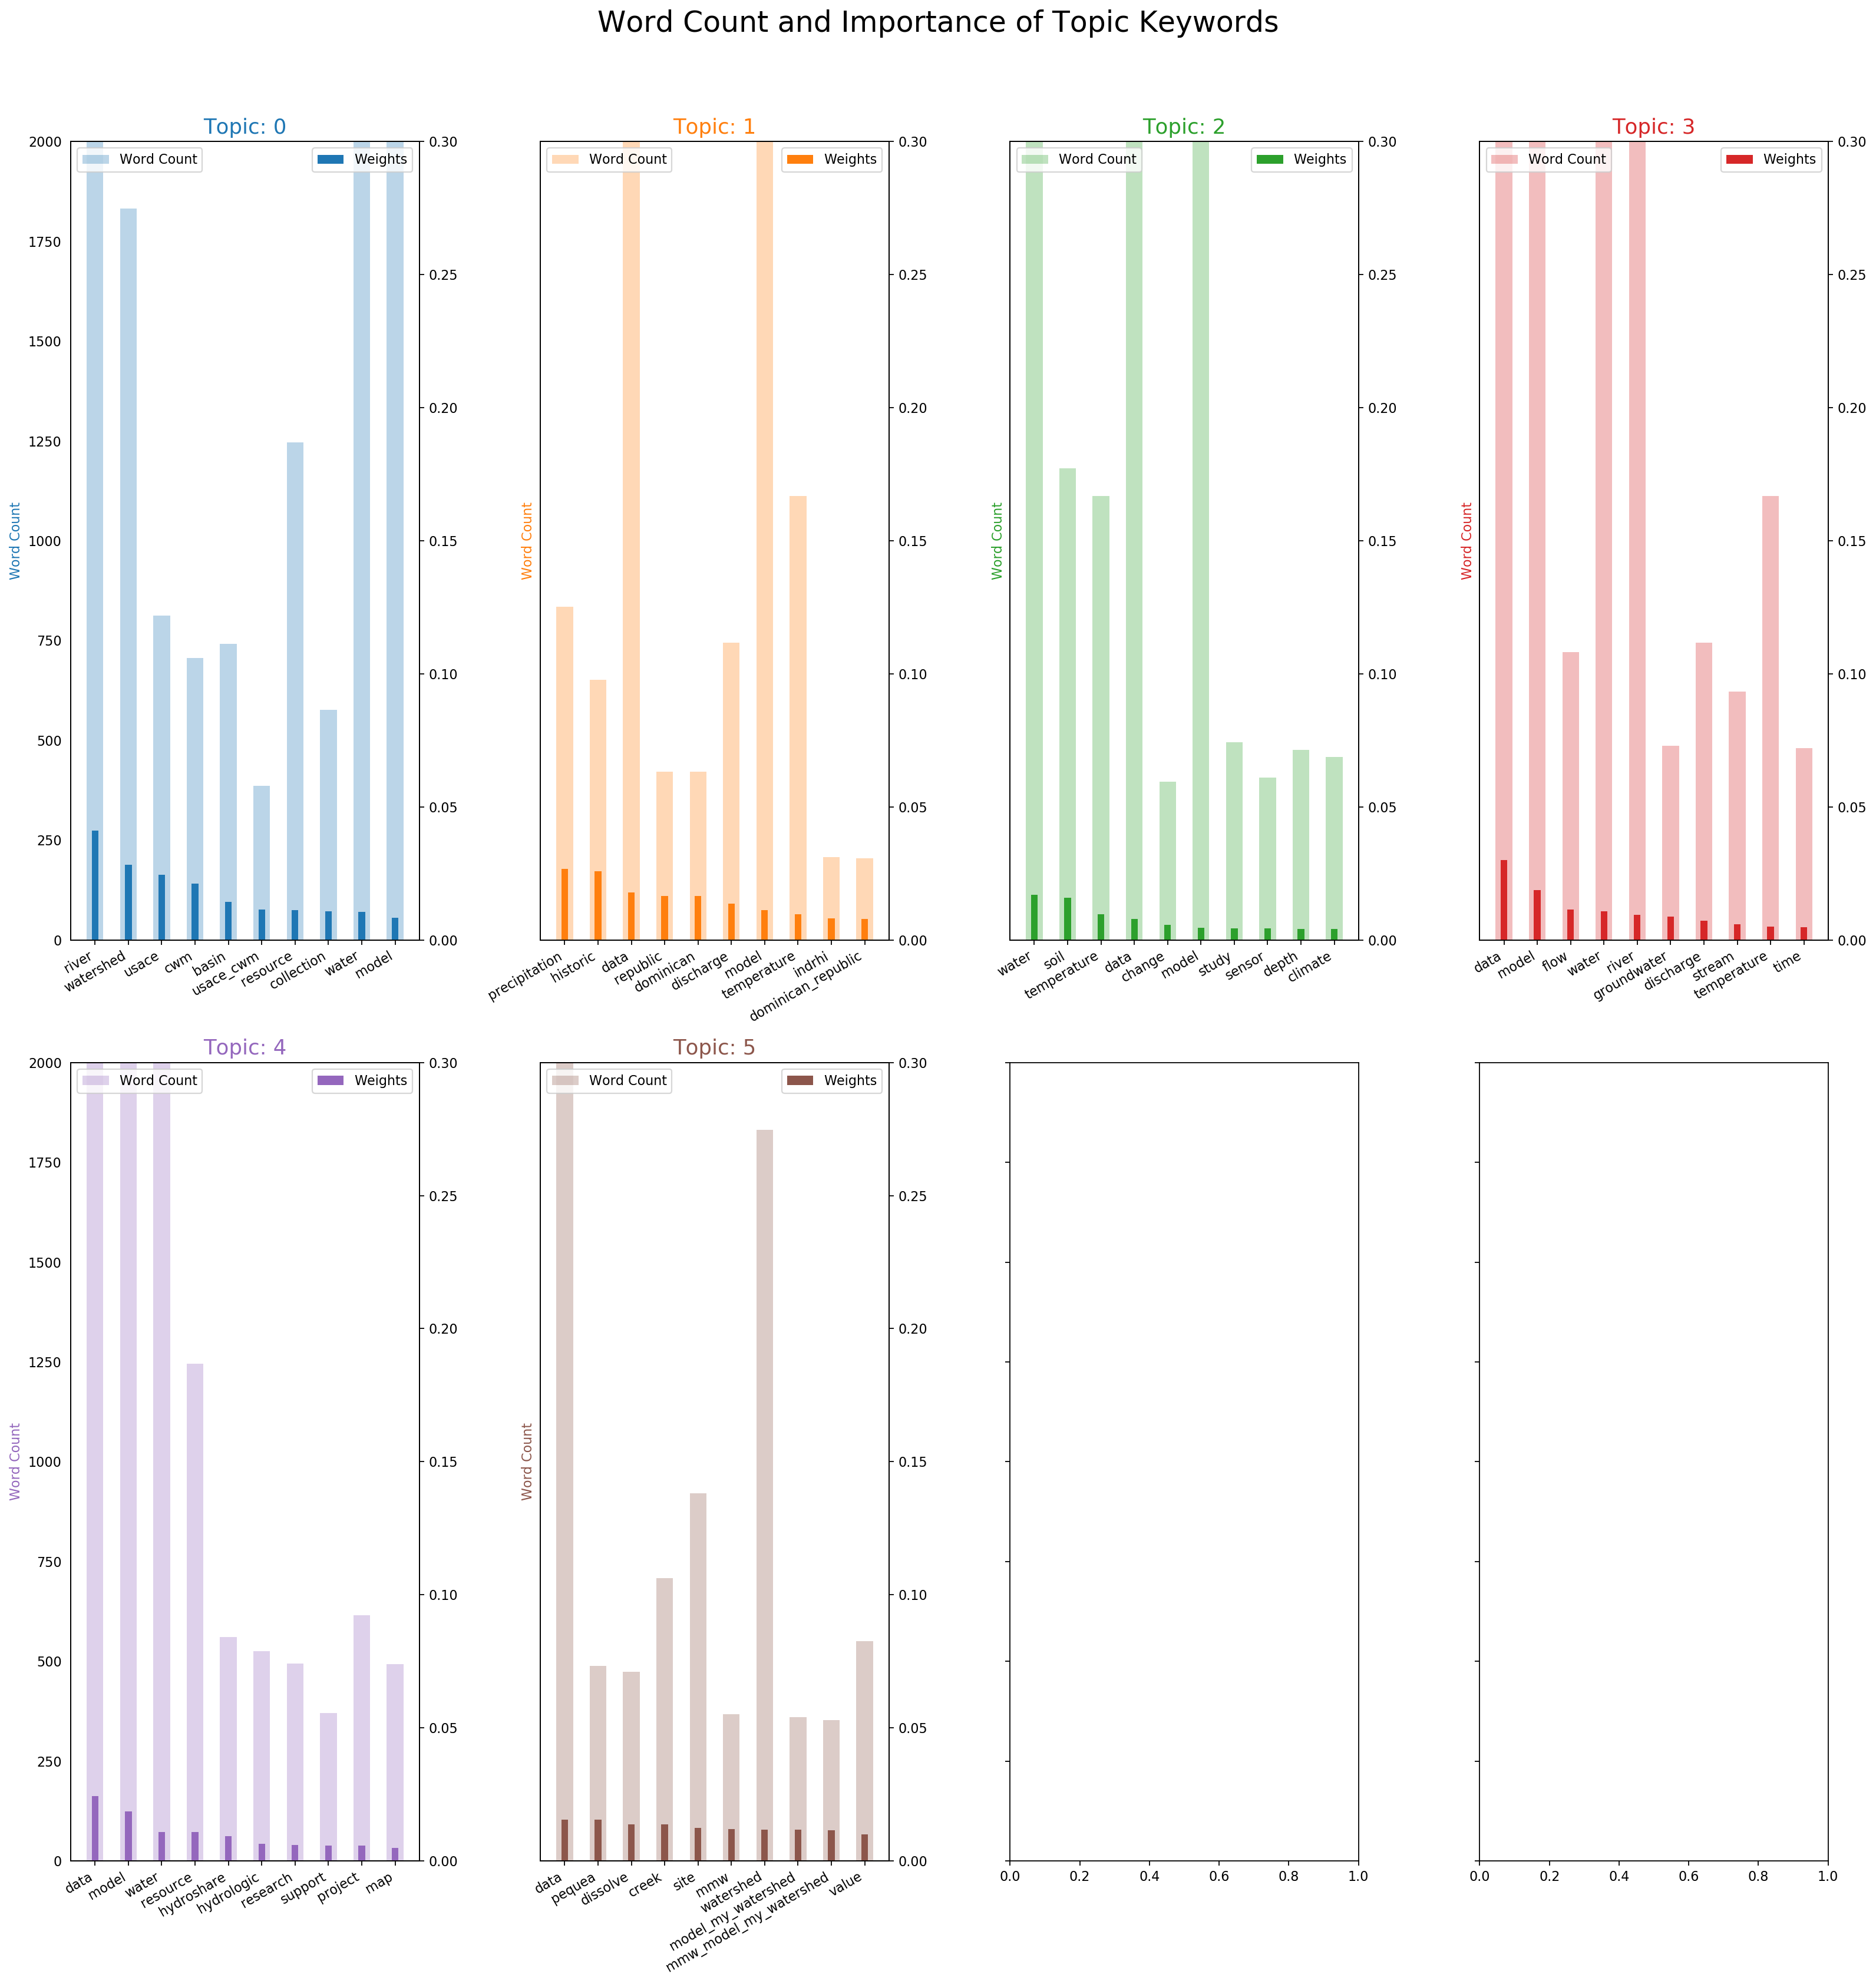

In [14]:
from collections import Counter
topics = model.show_topics(num_topics=num_of_topics, formatted=False)
data_flat = [w for w_list in docs for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])
df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 4, figsize=(20,20), sharey=True, dpi=160)
for i, ax in enumerate(axes.flatten()):
    if i >= len(topics):
        break
    clr = cols[i-len(cols)] if i >= len(cols) else cols[i]
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=clr, width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=clr, width=0.2, label='Weights')    
    ax.set_ylabel('Word Count', color=clr)
    ax_twin.set_ylim(0, 0.3); ax.set_ylim(0, 2000)
    ax.set_title('Topic: ' + str(i), color=clr, fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); 
    ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## **What are the most discussed topics in the training data**

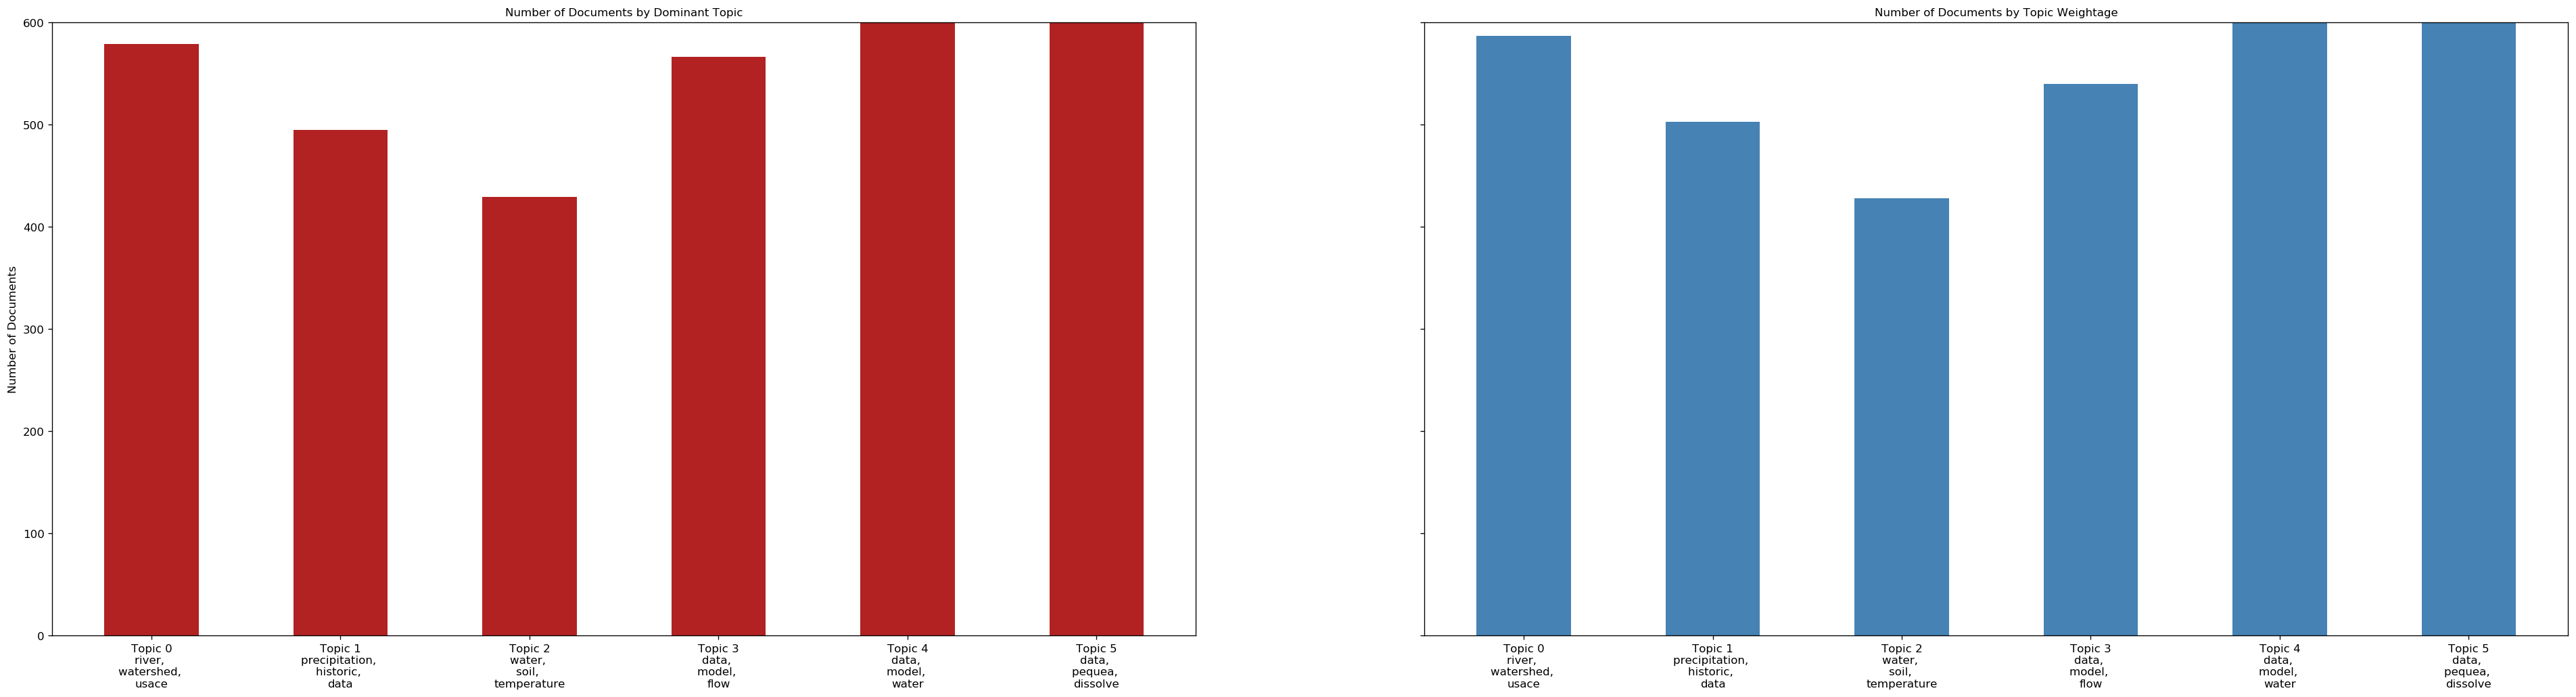

In [15]:
from matplotlib.ticker import FuncFormatter


dominant_topics, topic_percentages = topics_per_document(model=model, corpus=corpus)  

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in model.show_topics(num_topics=num_of_topics, formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40, 10), dpi=120, sharey=True)
# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 600)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

## **Visualize LDA model using pyLDAVis for training data**

In [16]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary=model.id2word, sort_topics=False)
vis

/opt/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.136760  0.239701       1        1  13.885903
1      0.086763 -0.112646       2        1   9.989498
2     -0.004657 -0.064774       3        1  22.426172
3     -0.062305 -0.051949       4        1  17.386433
4     -0.155247 -0.097857       5        1  23.814865
5      0.272207  0.087524       6        1  12.497126, topic_info=     Category         Freq           Term        Total  loglift  logprob
94    Default  1916.000000          river  1916.000000  30.0000  30.0000
109   Default   776.000000          usace   776.000000  29.0000  29.0000
659   Default   589.000000       historic   589.000000  28.0000  28.0000
22    Default   673.000000            cwm   673.000000  27.0000  27.0000
81    Default   755.000000  precipitation   755.000000  26.0000  26.0000
...       ...          ...            ...          ...      ...      ...
148    Topic6   445.197083           data  3939.911621  -0.1007  -4.1627
1246   Topic6   152.238419           snow   407.571869   1.0949  -5.2358
165    Topic6   150.917419        measure   425.679321   1.0427  -5.2445
117    Topic6   229.489166          water  2507.718018  -0.3116  -4.8254
398    Topic6   137.291885         stream   577.081482   0.6438  -5.3391

[424 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
916       1  0.199919    access
916       2  0.111719    access
916       3  0.023520    access
916       4  0.105839    access
916       5  0.552717    access
...     ...       ...       ...
462       4  0.124611      work
462       5  0.677053      work
1995      5  0.992441  workshop
2069      4  0.906485      wria
2069      5  0.090649      wria

[857 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6])

## **Test the model on test data unseen by the model**

In [21]:
#print("total number of test data keywords: ", len(test_keywords), ", keywords: ", test_keywords)
print("total number of test data keywords: ", len(test_keywords))
test_keywords_set = set(flatten(test_keywords))
#print(test_keywords_set)
print("number of test keywords in test_keywords_set", len(test_keywords_set))
print("Number of full test text rows:", len(test_data))

total number of test data keywords:  846
number of test keywords in test_keywords_set 1633
Number of full test text rows: 846


In [24]:
test_docs = [process_text(text) for text in test_data]

#Create Biagram & Trigram Models 
# Add bigrams and trigrams to texts
# higher threshold means few phrases, heavily depends on scoring function, which can be set as 'default' or 'npmi'
test_bigram = Phrases(test_docs, min_count=5, threshold=10, scoring='default') 
test_trigram = Phrases(test_bigram[test_docs])

for idx in range(len(test_docs)):
    for token in test_bigram[test_docs[idx]]:
        if '_' in token and token not in test_docs[idx]:
            # Token is a bigram, add to document.
            test_docs[idx].append(token)
            #print("in bigram processing: ", token)
    for token in test_trigram[test_docs[idx]]:
        if '_' in token and token not in test_docs[idx]:
            # Token is a bigram, add to document.
            test_docs[idx].append(token)
            #print("in trigram processing: ", token)

test_bows = [model.id2word.doc2bow(text) for text in test_docs]

test_sent_topics_df = pd.DataFrame()

for i, row_list in enumerate(model[test_bows]):
    row = row_list[0] if model.per_word_topics else row_list
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    for j, (topic_num, prop_topic) in enumerate(row):
        if j == 0:
            wp = model.show_topic(topic_num)
            topic_keywords_list = [word for word, prop in wp]
            topic_keywords = "; ".join(topic_keywords_list)
            # compute cosine similarity between topic keywords and input keywords
            topic_keywords_set = {w for w in topic_keywords_list}
            test_keywords_set = {w for w in test_keywords[i]}
            #rvector = topic_keywords_set.union(input_keywords_set)
            rvector = test_keywords_set
            l1 = []; l2 = []
            for w in rvector:
                if w in topic_keywords_set:
                    l1.append(1)
                else:
                    l1.append(0)
                if w in test_keywords_set:
                    l2.append(1)
                else:
                    l2.append(0)
            dot_product = sum(n1*n2 for n1, n2 in zip(l1, l2))
            mag1 = sum(l1)**0.5
            mag2 = sum(l2)**0.5
            if mag1 == 0 or mag2 == 0:
                cos_sim = 0
            else:    
                cos_sim = dot_product/(mag1*mag2)
            test_sent_topics_df = test_sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords, test_keywords[i], cos_sim]), ignore_index=True)
        else:
            break
            
contents = pd.Series(test_docs)
test_sent_topics_df = pd.concat([test_sent_topics_df, contents], axis=1)
test_sent_topics_df.reset_index()
test_sent_topics_df.columns = ['Dominant_Topic', 'Percent_Contribution', 'Topic_Keywords', 'Curated', 'Similarity', 'Text']
test_sent_topics_df

#doc_lda = model[bow]
#print('\ndoc_lda:', doc_lda)

#doc_topics, word_topics, phi_values = model.get_document_topics(bow, per_word_topics=True)
#for topic_id, prob in doc_topics:
#    terms = model.show_topic(topic_id)


,Dominant_Topic,Percent_Contribution,Topic_Keywords,Curated,Similarity,Text
0,5.0,0.9865,data; pequea; dissolve; creek; site; mmw; watershed; model_my_watershed; mmw_model_my_watershed;...,"[cbf, mmw, model_my_watershed, pequea]",0.866025,"[land, value, export, sub_watershed, pequea, creek, watershed, cbf, mmw, model_my_watershed, peq..."
1,5.0,0.9865,data; pequea; dissolve; creek; site; mmw; watershed; model_my_watershed; mmw_model_my_watershed;...,"[cbf, mmw, model_my_watershed, pequea]",0.866025,"[land, value, export, sub_watershed, pequea, creek, watershed, cbf, mmw, model_my_watershed, peq..."
2,3.0,0.4678,data; model; flow; water; river; groundwater; discharge; stream; temperature; time,"[hec_hms, rapidan_river, hms]",0.000000,"[rapidan, river, subbasin, uva, ce_, resource, model, outflow, usgs, station, hec_hms, software,..."
3,2.0,0.4704,water; soil; temperature; data; change; model; study; sensor; depth; climate,"[giswr16, usu, soil, giswr2016, hiroaki_shimada]",0.447214,"[significant, factor, soil, forming, cash, valley, proposal, term, paper, giswr, usu, soil, gisw..."
4,4.0,0.5207,data; model; water; resource; hydroshare; hydrologic; research; support; project; map,"[watershed_loading, data_collection, water_quality]",0.000000,"[pre, jordan, lake, report, resource, consist, various, report, document, prepare, army, corp, e..."
...,...,...,...,...,...,...
841,5.0,0.9971,data; pequea; dissolve; creek; site; mmw; watershed; model_my_watershed; mmw_model_my_watershed;...,"[gamut, rb_tm_c, climate_station, knowlton_fork, weo, raw_data, red_butte_canyon, tm_c, universi...",0.000000,"[wasatch, environmental, observatory, red, butte, network, todd, meadow, climate, rb_tm_c, datas..."
842,0.0,0.9870,river; watershed; usace; cwm; basin; usace_cwm; resource; collection; water; model,[corps_water_management_system],0.000000,"[usace, cwm, santa, ana, watershed, bank, usace, cwm, santa, ana, watershed, collection, resourc..."
843,0.0,0.9855,river; watershed; usace; cwm; basin; usace_cwm; resource; collection; water; model,[corps_management_water_management],0.000000,"[usace, cwm, big, sandy, river, watershed, river, usace, cwm, big, sandy, river, watershed, coll..."
844,2.0,0.8035,water; soil; temperature; data; change; model; study; sensor; depth; climate,"[dts, fiber_optic, ctemps]",0.000000,"[autonomous, distribute, temperature, sense, long_term, heat, application, remote, distribute, t..."


In [25]:
test_sent_topics_df.to_csv('testing_topic_info_data_frame_accurate.csv')

In [26]:
test_sim_series = test_sent_topics_df['Similarity']
test_zero_cnt = test_sim_series.astype(bool).sum()
print("mean of similarity measures: ", test_sim_series.mean())
print("number of zeros:", test_zero_cnt, "number of non-zeros:", test_sim_series.count()-test_zero_cnt)
print("mean of non-zero similarity measures: ", test_sim_series.replace(0, np.NaN).mean())

mean of similarity measures:  0.19476717778467936
number of zeros: 235 number of non-zeros: 611
mean of non-zero similarity measures:  0.7011618400248457


## **Find the most representative text for each topic in test data**

In [20]:
test_sent_topics_sorted_df = pd.DataFrame()
test_sent_topics_grp_df = test_sent_topics_df.groupby('Dominant_Topic')
for i, grp in test_sent_topics_grp_df:
    test_sent_topics_sorted_df = pd.concat([test_sent_topics_sorted_df, grp.sort_values(['Percent_Contribution'], ascending=False).head(1)], axis=0)
print("Mean of dominant_topic_percent_contribution: ", test_sent_topics_sorted_df[['Percent_Contribution']].mean(axis=0))    
# Reset Index    
test_sent_topics_sorted_df.reset_index(drop=True, inplace=True)
test_sent_topics_sorted_df

Mean of dominant_topic_percent_contribution:  Percent_Contribution    0.99665
dtype: float64


,Dominant_Topic,Percent_Contribution,Topic_Keywords,Curated,Text
0,0.0,0.9986,water; data; soil; temperature; site; stream; flow; measure; discharge; river,"[chlorophyll, respiration, stream_biofilm, diphenhydramine, dose_response, nitrogen_fixation, co...","[stream, biofilm, diphenhydramine, dose_response, experiment, resource, result, diphenhydramine,..."
1,1.0,0.9938,pequea; mmw; model_my_watershed; mmw_model_my_watershed; creek; watershed; cbf; export; land; su...,"[population_health, puerto_rico]","[population, health, report, puerto, rico, virgin, island, collection, health, summary, document..."
2,2.0,0.9971,historic; data; precipitation; republic; dominican; discharge; site; iutah; indrhi; dominican_re...,"[gamut, weo, girf_sd, raw_data, red_butte_canyon, girf, storm_drain, university_of_utah, red_but...","[wasatch, environmental, observatory, red, butte, network, raw, data, girf, storm, drain, rb_gir..."
3,3.0,0.9972,river; watershed; usace; cwm; basin; usace_cwm; collection; resource; water; system,"[meadow, map, shrub, illilouette, wetland, conifer, vegetation, yosemite]","[vegetation, map, illilouette, creek, basin, illilouette, creek, basin, yosemite, national, park..."
4,4.0,0.9952,model; water; data; dissolve; groundwater; sample; simulation; surface; input; support,"[karst_aquifer, groundwater_modeling, modflow, cfpv2, edwards_aquifer, karst]","[edward, aquifer, san, antonio, region, usa, transient, cfpv, model, model, data, set, conduit, ..."
5,5.0,0.9980,data; model; hydroshare; resource; notebook; hydrologic; snow; flood; map; web,"[rhessys, coweeta, rivanna, grass_gis, sub18, parallel]","[jupyter, notebook, demonstrate, summa, model, coweeta, sub, rivanna, hpc, hydrologic, model, gr..."


## **Visualize LDA model using pyLDAVis for test data**

In [21]:
test_vis = pyLDAvis.gensim.prepare(model, test_bows, dictionary=model.id2word, sort_topics=False)
test_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.044581 -0.091757       1        1  32.906406
1     -0.174748  0.198572       2        1   6.291763
2      0.280395  0.126699       3        1   7.405811
3     -0.023428 -0.164407       4        1  16.423706
4     -0.018622 -0.090029       5        1  13.904585
5     -0.108180  0.020922       6        1  23.067724, topic_info=    Category        Freq       Term       Total  loglift  logprob
94   Default  423.000000      river  423.000000  30.0000  30.0000
119  Default  379.000000  watershed  379.000000  29.0000  29.0000
109  Default  172.000000      usace  172.000000  28.0000  28.0000
659  Default  115.000000   historic  115.000000  27.0000  27.0000
75   Default  587.000000      model  587.000000  26.0000  26.0000
..       ...         ...        ...         ...      ...      ...
557   Topic6   46.993244   research  106.777496   0.6460  -5.5239
624   Topic6   37.286953  hydrology   60.982811   0.9748  -5.7553
919   Topic6   39.230503       base   76.254837   0.8021  -5.7045
117   Topic6   48.745708      water  549.078735  -0.9549  -5.4873
119   Topic6   42.494663  watershed  379.928253  -0.7239  -5.6245

[409 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
916       1  0.085000    access
916       2  0.048572    access
916       3  0.012143    access
916       4  0.218573    access
916       5  0.060715    access
...     ...       ...       ...
314       6  0.870223  workflow
1995      2  0.650247  workshop
1995      6  0.288999  workshop
7830      1  0.924724       wrf
2069      5  1.015981      wria

[730 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6])

In [27]:
model_file_name = '/projects/hackathon/ML-Training/hs-ml/data/model/hs_lda_model_6_topics'

# save model to disk
model.save(model_file_name)

In [18]:
topic_output_data = '/projects/hackathon/ML-Training/hs-ml/data/topic_data/topics_6.csv'

%time all_docs = [process_text(text) for text in all_texts]
all_bigram = Phrases(all_docs, min_count=5, threshold=10, scoring='default') 
all_trigram = Phrases(all_bigram[all_docs])

for idx in range(len(all_docs)):
    for token in all_bigram[all_docs[idx]]:
        if '_' in token and token not in all_docs[idx]:
            # Token is a bigram, add to document.
            all_docs[idx].append(token)
            #print("in bigram processing: ", token)
    for token in all_trigram[all_docs[idx]]:
        if '_' in token and token not in all_docs[idx]:
            # Token is a bigram, add to document.
            all_docs[idx].append(token)
            #print("in trigram processing: ", token)

all_corpus = [model.id2word.doc2bow(text) for text in all_docs]
print('number of documents in all_corpus', len(all_corpus))

CPU times: user 29.8 s, sys: 51.1 ms, total: 29.8 s
Wall time: 29.9 s
number of documents in all_corpus 4228


In [19]:
with open(topic_output_data, 'w', newline='', encoding='utf-8') as f:
    output_writer = csv.writer(f)
    header_list = ['UUID', 'Status', 'Title', 'Keywords', 'Topics']
    output_writer.writerow(header_list)
    cnt = 0
    for i, row_list in enumerate(model[all_corpus]):
        row = row_list[0] if model.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = model.show_topic(topic_num, topn=20)
                topic_keywords = "; ".join([word for word, prop in wp])
                output_writer.writerow([all_data[i][0], all_data[i][1], all_data[i][2], all_data[i][3], topic_keywords])
                cnt += 1
            else:
                break
            
    print('cnt=', cnt)

cnt= 4228
